## Import modules

In [1]:
import numpy as np

# to get and read data
import os
import requests
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import copy

# for splitting data and evaluating results
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to track progress
from tqdm.notebook import tqdm

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## get and read data

get data

In [2]:
# download zip

if not os.path.exists('CharacterTrajectories.zip'):
    url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip'
    r = requests.get(url, allow_redirects=True)
    open('CharacterTrajectories.zip', 'wb').write(r.content)
    print('zip downloaded')
else:
    print('zip already exists')


# extract folder from zip
if not os.path.exists('CharacterTrajectories'):
    with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall('CharacterTrajectories')
    print('folder extracted from zip')
else:
    print('zip already extracted')

zip downloaded
folder extracted from zip


read data

In [3]:
# arff -> (data,meta)
train_data, train_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')
test_data, test_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')

print(train_meta)
print(train_data[0])

Dataset: CharacterTrajectories
	CharacterTrajectories_attribute's type is relational
	target's type is nominal, range is ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20')

(array([(-0.13015 , -0.183121, -0.234104, -0.279929, -0.321851, -0.363783, -0.4095  , -0.460814, -0.517526, -0.57844 , -0.642335, -0.708369, -0.776037, -0.844799, -0.913359, -0.978872, -1.036865, -1.082398, -1.111614, -1.122168, -1.112322, -1.080184, -1.024236, -0.944604, -0.843469, -0.724226, -0.590649, -0.446936, -0.297932, -0.148794, -0.004546,  0.13014 ,  0.251447,  0.357344,  0.4482  ,  0.526596,  0.596567,  0.662582,  0.728357, 0.795736, 0.864318, 0.932146, 0.996691, 1.055067, 1.103557, 1.137583, 1.152673, 1.145736, 1.115602, 1.062653, 0.988309, 0.895041, 0.786664, 0.668248, 0.545463, 0.423899, 0.308732, 0.203901, 0.11002 , 0.023092, -0.062932, -0.151422, -0.241478, -0.33061 , -0.417377, -5.01012e-01, -5.79531e-01, -6.48897e-01, -7.03882e-01, -0.7396

In [4]:
train_inputs, train_labels = list(zip(*train_data))
test_inputs, test_labels = list(zip(*test_data))

# convert to np array
train_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in train_inputs])
test_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in test_inputs])

train_labels = np.array(train_labels, dtype=int)
test_labels = np.array(test_labels, dtype=int)

# subtract 1 from labels to start indexing from 0
train_labels -= 1; test_labels -= 1
print("labels :  ", np.unique(train_labels))

labels :   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


max length = 180


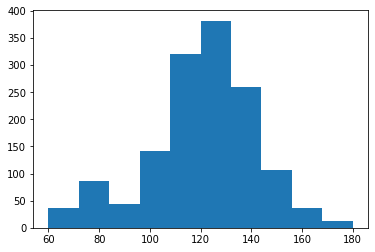

In [5]:
# Distribution of sample lenghts
lengths = []

for input in train_inputs:
  len1 = np.where(np.isnan(input[0]))[0][0]
  lengths.append(len1)

max_len = np.max(lengths)
print('max length =',max_len)
_ = plt.hist(lengths)
plt.show()

In [6]:
train_inputs = np.nan_to_num(train_inputs)
test_inputs = np.nan_to_num(test_inputs)

# split train into train and validation
train_inputs, val_inputs, train_labels, val_labels, = train_test_split(train_inputs, train_labels, test_size=0.25, random_state=0)

classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_inputs),'samples')
print('\nval data contains',len(val_inputs),'samples')
print('test data contains',len(test_inputs),'samples')

print('\neach sample has 3 channels : x,y and force')
print('length of each channel is',len(train_inputs[0][0]))
print('nan values have been replaced by 0')

number of classes : 20

train data contains 1066 samples

val data contains 356 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force
length of each channel is 182
nan values have been replaced by 0


## visualize characters

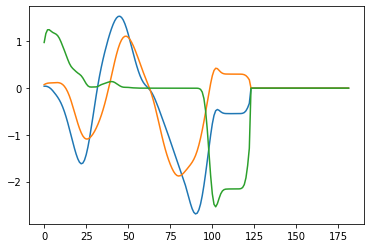

In [7]:
plt.plot(np.transpose(train_inputs[0]))
plt.show()

function to plot char

In [8]:
def plot_charVector(char):

  fig, axs = plt.subplots(1,2,figsize=(10,5))
  
  xVel  = char[0]
  yVel  = char[1]
  force = char[2]
  
  xPos  = np.cumsum(xVel)
  yPos  = np.cumsum(yVel)
  #remove last element and insert 0 to the beginning
  xPos  = np.insert(xPos[:-1],0,0)
  yPos  = np.insert(yPos[:-1],0,0)    
  
  #normalize force between 0 and 1
  color = (force - np.min(force)) / (np.max(force)-np.min(force))
  #define color based on force
  colormap = cm.inferno
  
  axs[0].quiver( xPos,yPos, xVel,yVel, color=colormap(color) )
  axs[1].plot(xPos,yPos,'o')
  
  plt.show()

visualize one character of each class

a


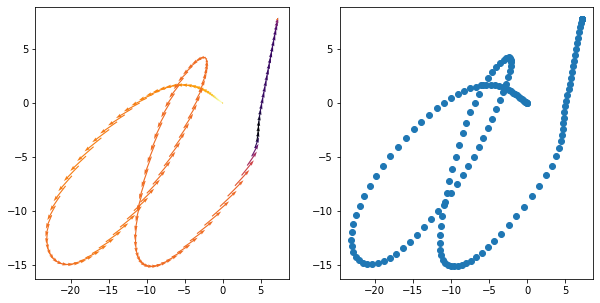

b


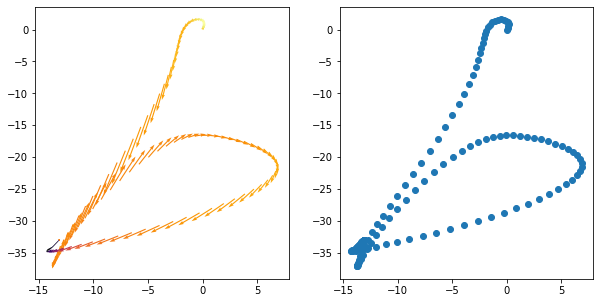

c


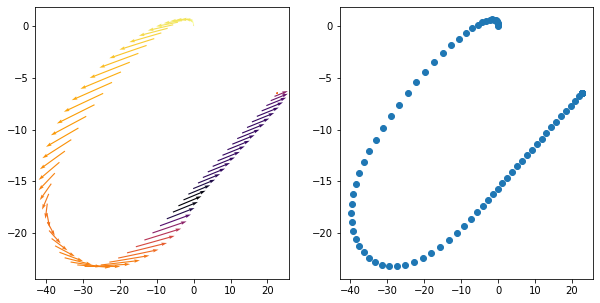

d


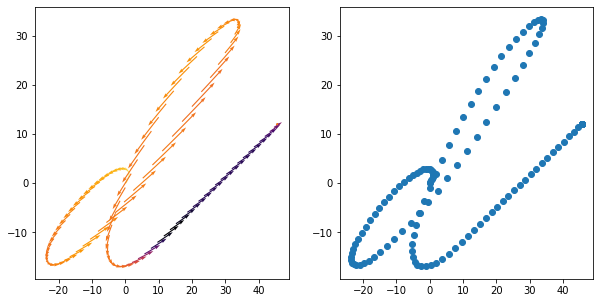

e


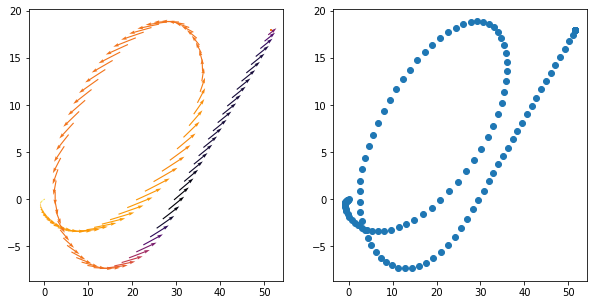

g


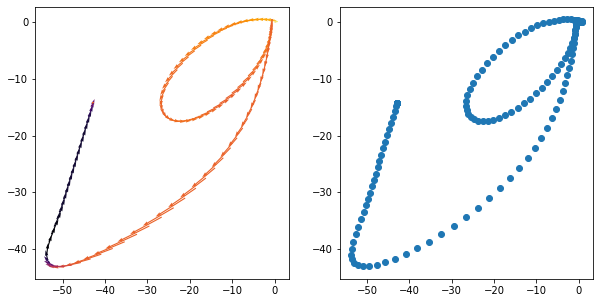

h


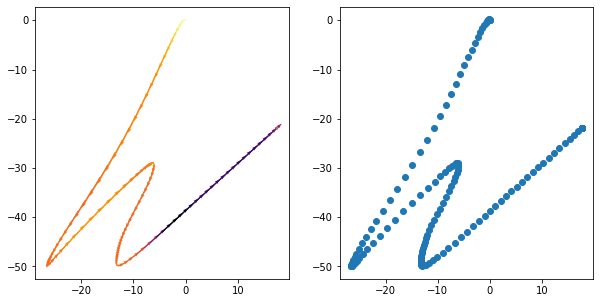

l


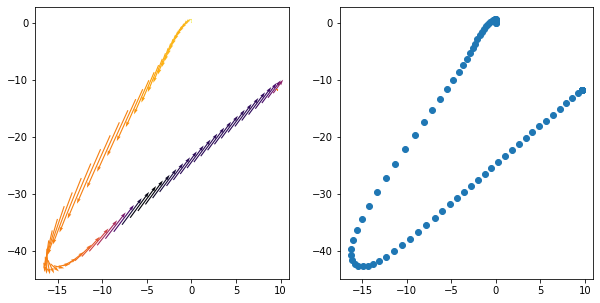

m


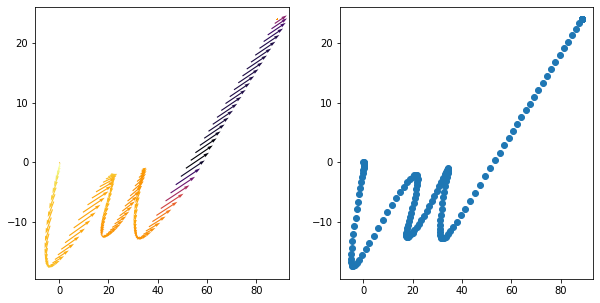

n


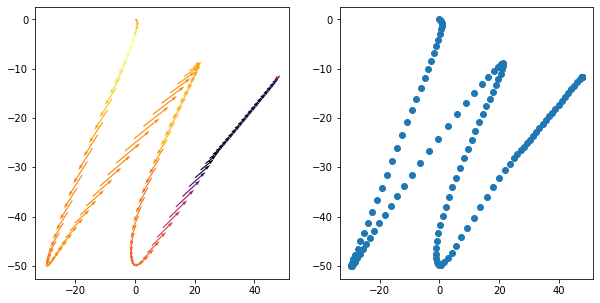

o


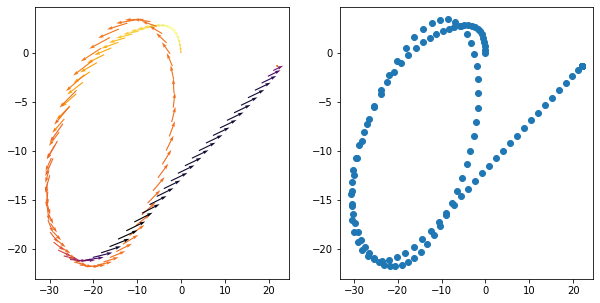

p


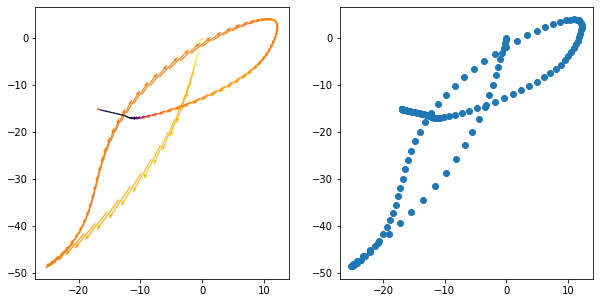

q


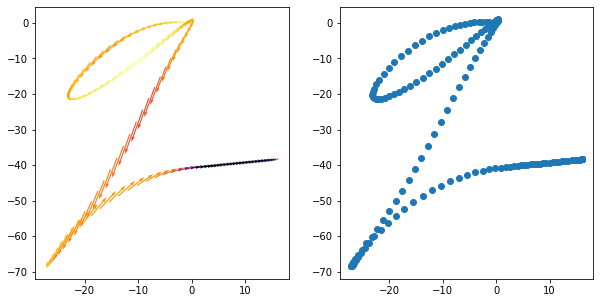

r


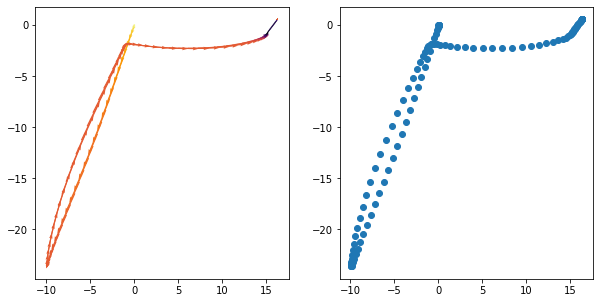

s


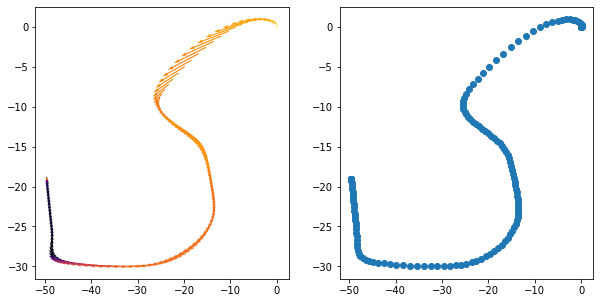

u


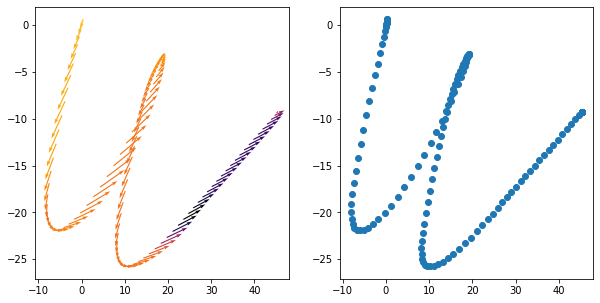

v


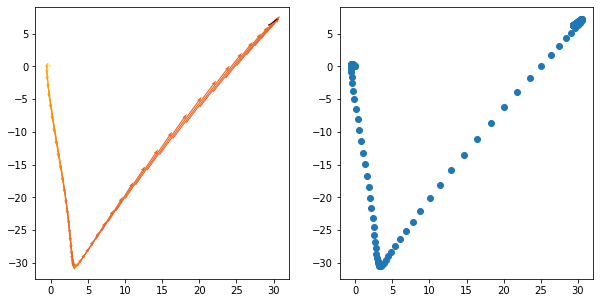

w


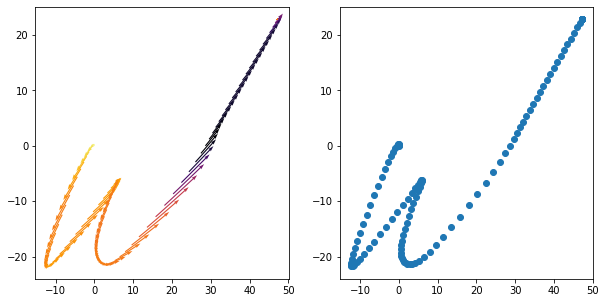

y


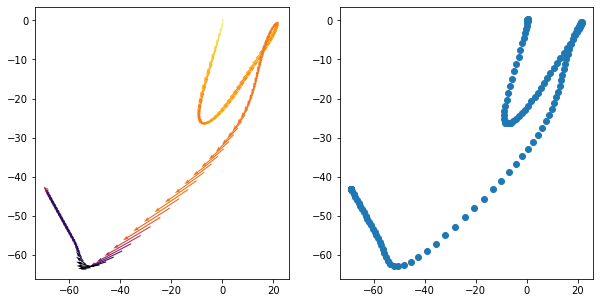

z


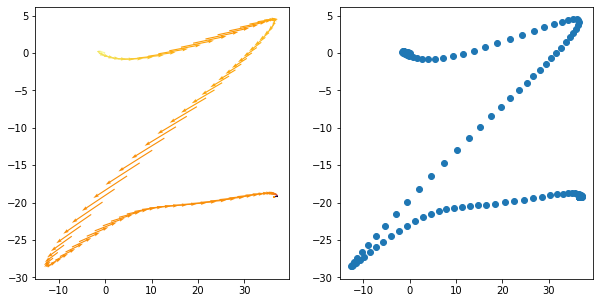

In [9]:
for i,class1 in enumerate(classes):
  indexes = np.where(train_labels==i)[0]
  np.random.seed(0)
  random_index = np.random.choice(indexes)
  print(class1)
  plot_charVector(train_inputs[random_index])

## conv net

### create dataloader

In [10]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = inputs
    self.labels = labels

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.inputs[index]
    label = self.labels[index]
    return input,label
    

train_dataset = mydataset(train_inputs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = mydataset(val_inputs, val_labels)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

test_dataset = mydataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

### define the network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input channels, 8 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(3, 8, 3)
        self.conv2 = nn.Conv1d(8, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(704, 120) 
        self.fc2 = nn.Linear(120, 20)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)        

In [12]:
inp_size = 182; c0 = 3
k_conv = 3; k_pool = 2; c1 = 8; c2 = 16

print("initial size  of  sample = %d x %d" % (c0,inp_size))
conv1_outSize = inp_size-(k_conv-1)
print("output  size after conv1 = %d x %d" % (c1,conv1_outSize))
pool1_outSize = np.floor((conv1_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool1 = %d x %d" % (c1,pool1_outSize))

conv2_outSize = pool1_outSize-(k_conv-1)
print("output  size after conv2 = %d x %d" % (c2,conv2_outSize))
pool2_outSize = np.floor((conv2_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool2 = %d x %d" % (c2,pool2_outSize))

print(c2*pool2_outSize)

initial size  of  sample = 3 x 182
output  size after conv1 = 8 x 180
output  size after pool1 = 8 x 90
output  size after conv2 = 16 x 88
output  size after pool2 = 16 x 44
704.0


In [13]:
net = Net().to(device)
print(count_parameters(net))

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

87500


### train



In [14]:
def trainNet(net,criterion,optimizer,train_loader,val_loader,epochs,check_every=None,earlyStopping=False):

  print("training network")

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  avg_trainLosses = []
  avg_valLosses = []

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []

    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_loader):

        inputBatch = inputBatch.to(device).float()
        labelBatch = labelBatch.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        train_loss.append(loss.item())

        # backward + optimize
        loss.backward()
        optimizer.step()

    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(val_loader):
      with torch.no_grad():

        inputBatch = inputBatch.to(device).float()
        labelBatch = labelBatch.to(device)

        # forward
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())

    avg_trainLoss = np.mean(train_loss)
    avg_valLoss = np.mean(val_loss)
    avg_trainLosses.append(avg_trainLoss)

    if epoch > 0:
      if avg_valLoss < min(avg_valLosses):
        best_params = copy.deepcopy(net.state_dict())
        best_epoch, best_loss = epoch, avg_valLoss
    else:
      movAvg_old = avg_valLoss    
    avg_valLosses.append(avg_valLoss)   

    # print statistics
    if epoch % check_every == check_every - 1:
      print('epoch: %d  | train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss), end="  | ")
      movAvg_new = np.mean(avg_valLosses[epoch+1-check_every:epoch+1])
      print('avg train loss: %.3f, avg val loss: %.3f' % (np.mean(avg_trainLosses[epoch+1-check_every:epoch+1]), movAvg_new))

      if earlyStopping:
        if movAvg_old < movAvg_new:
          break
        else:
          movAvg_old = movAvg_new



  print('Finished Training')
  plt.plot(avg_trainLosses, label='train loss')
  plt.plot(avg_valLosses, label='val loss')
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params

training network


epoch: 30  | train loss: 0.467, val loss: 0.484  | avg train loss: 1.929, avg val loss: 1.941
epoch: 60  | train loss: 0.081, val loss: 0.208  | avg train loss: 0.194, avg val loss: 0.273
epoch: 90  | train loss: 0.029, val loss: 0.150  | avg train loss: 0.048, avg val loss: 0.167
epoch: 120  | train loss: 0.015, val loss: 0.150  | avg train loss: 0.021, avg val loss: 0.155
epoch: 150  | train loss: 0.010, val loss: 0.147  | avg train loss: 0.012, avg val loss: 0.153
epoch: 180  | train loss: 0.007, val loss: 0.153  | avg train loss: 0.008, avg val loss: 0.151

Finished Training


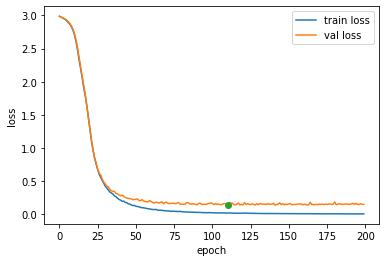

In [15]:
best_params = trainNet(net, criterion, optimizer, train_loader, val_loader, epochs=200, check_every=30, earlyStopping=True)

In [16]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate

In [17]:
def evaluate(net, inputs, output_true):
  net.eval()
  output_pred = []

  with torch.no_grad():
    for input in tqdm(inputs):      
      output = net(torch.from_numpy(input).unsqueeze(0).float().to(device)).cpu().numpy()
      output = np.argmax(output)
      output_pred.append(output)

  print(classification_report(output_true, output_pred, target_names=classes, digits=4))

In [18]:
print("evaluation results on train data")
evaluate(net,train_inputs,train_labels)
print("evaluation results on test data")
evaluate(net,test_inputs,test_labels)

evaluation results on train data



              precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000        56
           b     1.0000    1.0000    1.0000        61
           c     1.0000    1.0000    1.0000        57
           d     1.0000    1.0000    1.0000        55
           e     1.0000    1.0000    1.0000        74
           g     1.0000    1.0000    1.0000        46
           h     1.0000    0.9762    0.9880        42
           l     1.0000    1.0000    1.0000        63
           m     1.0000    1.0000    1.0000        51
           n     1.0000    0.9245    0.9608        53
           o     1.0000    1.0000    1.0000        52
           p     1.0000    1.0000    1.0000        55
           q     1.0000    1.0000    1.0000        44
           r     1.0000    1.0000    1.0000        43
           s     1.0000    1.0000    1.0000        47
           u     1.0000    1.0000    1.0000        48
           v     1.0000    1.0000    1.0000        60
           w     0.8958   


              precision    recall  f1-score   support

           a     1.0000    0.9767    0.9882        86
           b     0.9726    1.0000    0.9861        71
           c     1.0000    0.9859    0.9929        71
           d     0.9875    1.0000    0.9937        79
           e     1.0000    0.9570    0.9780        93
           g     0.9853    0.9710    0.9781        69
           h     1.0000    0.9375    0.9677        64
           l     0.9775    1.0000    0.9886        87
           m     0.9194    0.9048    0.9120        63
           n     0.9180    0.8615    0.8889        65
           o     1.0000    0.9296    0.9635        71
           p     1.0000    1.0000    1.0000        66
           q     0.9841    1.0000    0.9920        62
           r     0.9500    0.9500    0.9500        60
           s     0.9710    1.0000    0.9853        67
           u     0.9296    1.0000    0.9635        66
           v     1.0000    0.9615    0.9804        78
           w     0.7778   